In [38]:
import torch
import random
import numpy as np
from deepSVDD import DeepSVDD
from datasets.main import load_dataset
from base.base_dataset import BaseADDataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

In [39]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        """
        初始化 Dataset
        :param data: 已處理的特徵數據 (NumPy array or Pandas DataFrame)
        :param labels: 對應的標籤數據
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        """返回數據集大小"""
        return len(self.data)

    def __getitem__(self, idx):
        """根據索引返回一筆數據及其標籤"""
        return self.data[idx], self.labels[idx], idx

class MyADDataset(BaseADDataset):
    def __init__(self):
        super().__init__(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')

    def process_data(self, file_path):
        # 讀取資料
        df=pd.read_csv(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')
        for i in range(2, 16):
            tmp = pd.read_csv(r'multiclass15\csv_result-data'+str(i)+' Sampled Scenarios.csv')
            df = pd.concat([df, tmp], ignore_index=True)
        
        # df = pd.read_csv(file_path)
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        df = df.drop('id', axis=1)
        
        # 標籤處理
        y = df['marker']
        y = [0 if value in [41] else 1 for value in y]
        X = df.drop('marker', axis=1)

        # 刪除不必要的欄位
        columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                        'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                        'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
        X = X.drop(columns=columns_to_drop, axis=1)
        
        # 分割數據集
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # PCA 降維
        # pca = PCA(n_components=15)
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

        X_train_df = pd.DataFrame(X_train)
        y_train_df = pd.DataFrame(y_train, columns=['label'])

        X_train_df.reset_index(drop=True, inplace=True)
        y_train_df.reset_index(drop=True, inplace=True)

        merged_df = pd.concat([X_train_df, y_train_df], axis=1)
        
        label_0_data = merged_df[merged_df['label'] == 0]
        train_data = label_0_data.drop('label', axis=1)

        # Min-Max 標準化
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(train_data)
        X_test = scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

    def create_dataloaders(self, file_path, batch_size=32, num_workers=0):
        # 處理數據
        X_train, X_test, y_train, y_test = self.process_data(file_path)

        # 建立 Dataset
        train_dataset = CustomDataset(X_train, y_train)
        test_dataset = CustomDataset(X_test, y_test)

        # 建立 DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        return train_loader, test_loader
    
    def loaders(self, batch_size, shuffle_train=True, shuffle_test=False, num_workers = 0):
        train_loader, test_loader = self.create_dataloaders(self.root, batch_size=batch_size)
        return train_loader, test_loader


def test_deep_svdd():
    # 隨便填一些測試參數
    net_name = 'feature_net'
    normal_class = 0
    nu = 0.1
    objective = 'one-class'
    device = 'cuda'

    print("開始測試 DeepSVDD...")

    # 初始化 DeepSVDD 並設定網路
    deep_svdd = DeepSVDD(objective, nu)
    deep_svdd.set_network(net_name)

    data = MyADDataset()

    # 測試 train
    print("開始訓練...")
    deep_svdd.train(
        data,
        optimizer_name='adam',
        lr=0.001,
        n_epochs=100, 
        lr_milestones=[],
        batch_size=64,
        weight_decay=1e-6,
        device=device,
        n_jobs_dataloader=0
    )
    print("訓練完成。")

    # 測試 test
    print("開始測試...")
    deep_svdd.test(data, device=device, n_jobs_dataloader=0)

    print("測試完成。")

    return deep_svdd.results, deep_svdd.getNet(), data, deep_svdd

In [40]:
results, net, dataset, dsvdd = test_deep_svdd()

開始測試 DeepSVDD...
開始訓練...


c:\Users\user\AppData\Local\anaconda3\envs\DeepSVDD\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


訓練完成。
開始測試...
測試完成。


In [ ]:
def compute_threshold(train_loader: DataLoader, net, c, quantile: float = 0.99, device: str = 'cuda'):
    """
    計算 One-Class DeepSVDD 模型的閾值。

    Args:
        train_loader (DataLoader): 訓練數據的 DataLoader。
        net (BaseNet): 已訓練的神經網絡模型。
        c (torch.Tensor): 超球體中心。
        quantile (float): 設定分位數 (默認為 0.95)。
        device (str): 訓練時使用的設備 (默認為 'cuda')。

    Returns:
        float: 基於訓練數據計算的閾值。
    """

    net.eval()  # 設置網絡為評估模式
    distances = []  # 用於存儲每個樣本到中心的距離

    with torch.no_grad():  # 禁用梯度計算
        for data in train_loader:
            inputs, _, _ = data
            inputs = inputs.to(device)

            # 網絡輸出
            outputs = net(inputs)

            # 計算每個樣本到中心的距離
            dist = torch.sqrt(torch.sum((outputs - c) ** 2, dim=1))
            distances.append(dist.cpu().numpy())

    # 合併所有批次的距離
    distances = np.concatenate(distances)

    # 根據分位數計算閾值
    threshold = np.quantile(distances, quantile)
    return threshold

In [42]:
train_loader, test_loader = dataset.loaders(batch_size=64, num_workers=0)

threashold = compute_threshold(train_loader, net, dsvdd.trainer.c, device='cuda')

In [43]:
threashold

0.0006111855909693986

In [44]:
y_score = []
y_true = []
for i in results['test_scores']:
    y_score.append(i[2])
    y_true.append(i[1])

In [45]:
len(y_score)

14415

In [46]:
y_pred = []

for i in range(len(y_score)):
    if y_score[i] > threashold:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [47]:
results['test_auc']

0.9290576371578235

In [48]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(y_true, y_score)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.9290576371578235


In [49]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")

Accuracy: 0.9202219909816164
F1 Score: 0.9584537572254336
Precision: 0.9377209105047363
Recall: 0.9801241318161666


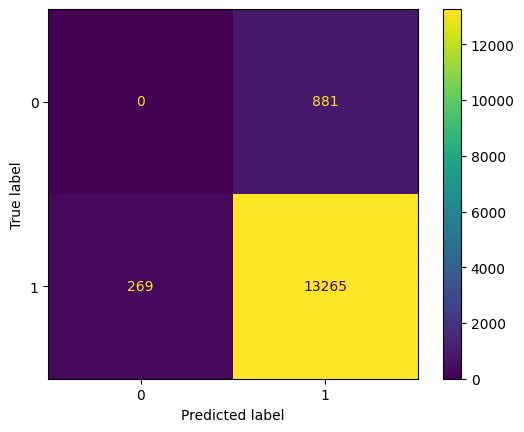

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are defined
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()